In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import numpy as np
import cv2 as cv
import math

In [15]:
#------------------------------------------------------------------------------------------------------------------------------

def lin_clf(data, percent): # функция разделяющая данные на 2 класса: трещины и не трещины
    point = (max(data.value.values) - min(data.value.values)) * percent
    new_values = []
    for i in data.value:
        if i >= point:
            new_values.append(1)
        else:
            new_values.append(0)

    data['value'] = new_values

    return data

#------------------------------------------------------------------------------------------------------------------------------

def calс_fd(data, S): # функция рассчитывающая отношение густоты трещиноватости к единице площади
    fd = []
    L = math.sqrt(S)
    for i in range(len(data.X.values)):
        min_X, max_X = data[i:i+1].X.values[0] - L , data[i:i+1].X.values[0] + L
        min_Y, max_Y = data[i:i+1].Y.values[0] - L , data[i:i+1].Y.values[0] + L
        q = data.query(" X > @min_X & X < @max_X & Y > @min_Y & Y < @max_Y ")
        fd.append(q.value.mean())

    data['fd'] = fd
    
    return data
    
#------------------------------------------------------------------------------------------------------------------------------

def get_sq(data, coordinate_X, coordinate_Y, S):         # функция получаюющая данные квадрата указанной                                            
    L = math.sqrt(S)                                     # площади в указанных координатах
    min_X, max_X = coordinate_X - L , coordinate_X + L
    min_Y, max_Y = coordinate_Y - L , coordinate_Y + L
    q = data.query(" X > @min_X & X < @max_X & Y > @min_Y & Y < @max_Y ")
    atr = q.pivot_table(    index='Y', 
                        columns='X', 
                        values='value', 
                        aggfunc=sum).to_numpy()

    plt.figure(figsize=(10,10))
    sns.heatmap(atr, cmap="YlGnBu", xticklabels=False, yticklabels=False, cbar=False)
    plt.savefig('image.jpg')
        
#------------------------------------------------------------------------------------------------------------------------------

def get_angles(build_plot=False):   # функция получаюющая углы распространения трещин с помощью компьюторного зрения
    hsv_min = np.array((0, 54, 5), np.uint8)
    hsv_max = np.array((187, 255, 253), np.uint8)

    color_blue = (255,0,0)
    color = (220,20,60)

    img = cv.imread('image.jpg')

    hsv = cv.cvtColor( img, cv.COLOR_BGR2HSV ) # меняем цветовую модель с BGR на HSV
    thresh = cv.inRange( hsv, hsv_min, hsv_max ) # применяем цветовой фильтр
    contours0, hierarchy = cv.findContours( thresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    angles = []
    
    # перебираем все найденные контуры в цикле
    for cnt in contours0:
        rect = cv.minAreaRect(cnt) # пытаемся вписать прямоугольник
        box = cv.boxPoints(rect) # поиск четырех вершин прямоугольника
        box = np.int0(box) # округление координат
        center = (int(rect[0][0]),int(rect[0][1]))
        

        # вычисление координат двух векторов, являющихся сторонами прямоугольника, а так же длину этих сторон
        edge1 = np.int0((box[1][0] - box[0][0],box[1][1] - box[0][1]))
        edge2 = np.int0((box[2][0] - box[1][0], box[2][1] - box[1][1]))
        L1 = cv.norm(edge1)
        L2 = cv.norm(edge2)
        
        # избавляемся от геометрий которые не можем считать трещинами 
        
        if L1 == L2:
            continue 
        elif L1 > L2:
            if L1/L2 < 1.3:
                continue
            usedEdge = edge1     
        else:
            if L2/L1 < 1.3:
                continue
            usedEdge = edge2
            
        reference = (1,0) # вектор, задающий горизонт
        
        # расчитываем углы распространения трещин
        angle = 180.0/math.pi * math.acos((reference[0] * usedEdge[0] + reference[1]*usedEdge[1]) / 
                (cv.norm(reference) * cv.norm(usedEdge)))
        angles.append(angle + 90)
        all_angles = []
        
        for a in angles:
            all_angles.append(a)
            if a > 180:
                all_angles.append(int(a - 180))
            else:
                all_angles.append(int(a + 180))
                
        if build_plot:       
            cv.drawContours(img,[box],0,(255,0,0),2) 
            cv.circle(img, center, 5, color, 2) 
            cv.putText(img, "%d" % int(angle+90), (center[0]+20, center[1]-20), 
                       cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    if build_plot:    
        cv.imshow('contours', img)
        cv.waitKey()
        cv.destroyAllWindows()
          
    return all_angles

#------------------------------------------------------------------------------------------------------------------------------    

def build_rose(all_angles): # функция для построения розы-диаграммы азимутальной направленности
    # рассчитываем количество углов входящих в 10-градусный интервал
    start = 180
    count_ang = []
    while start != 360:
        end = start + 10
        count_ang.append(len([x for x in all_angles if x > start and x < end+0.1]))
        start = end   
    count_ang.reverse()
    count_ang = count_ang * 2 
    
    # преобразовываем полученные частоты в массив данных для построения розы-диаграммы
    max_len = max(count_ang)
    C = np.array([])
    for i in count_ang:
        my_list = []
        for j in range(i):
            my_list.append(1)
        for k in range(max_len - i):
            my_list.append(0)
            
        C = np.append(C, my_list, axis=0)
    C = C.reshape(len(count_ang), max_len)  
    C = np.reshape(C, len(count_ang)*max_len, order='F')
    C = C.reshape(max_len, len(count_ang))
    
    # создаём систему координат 
    theta = np.linspace(0,2*np.pi, len(count_ang)+1)
    r = np.linspace(0.1,1,max_len+1)
    Theta, R = np.meshgrid(theta, r)
    C = np.ma.masked_less_equal(C,0.5)
    
    # построение розы-диаграммы
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='polar')
    ax.pcolormesh(Theta, R, C, edgecolors = 'black', linewidth = 0.01)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    ax.set_title("Роза-диаграмма трещинноватости", loc='center')
    ax.set_yticklabels([])
    plt.tight_layout()
    plt.show() 
    
#------------------------------------------------------------------------------------------------------------------------------  
   

-1.000000    131562
-0.800000       363
-1.000490       215
-1.000489       101
-1.000488        86
              ...  
-0.940591         1
-0.677896         1
-0.727881         1
-0.439591         1
-0.938542         1
Name: value, Length: 30750, dtype: int64

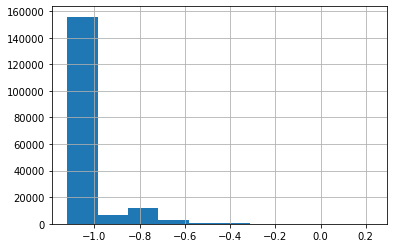

In [3]:
data = pd.read_csv('C://Users/SMA_9/Desktop/Seismic/points.csv',sep=' ',names=['X', 'Y', 'value'], header=None)
data.value.hist()
data.value.value_counts()

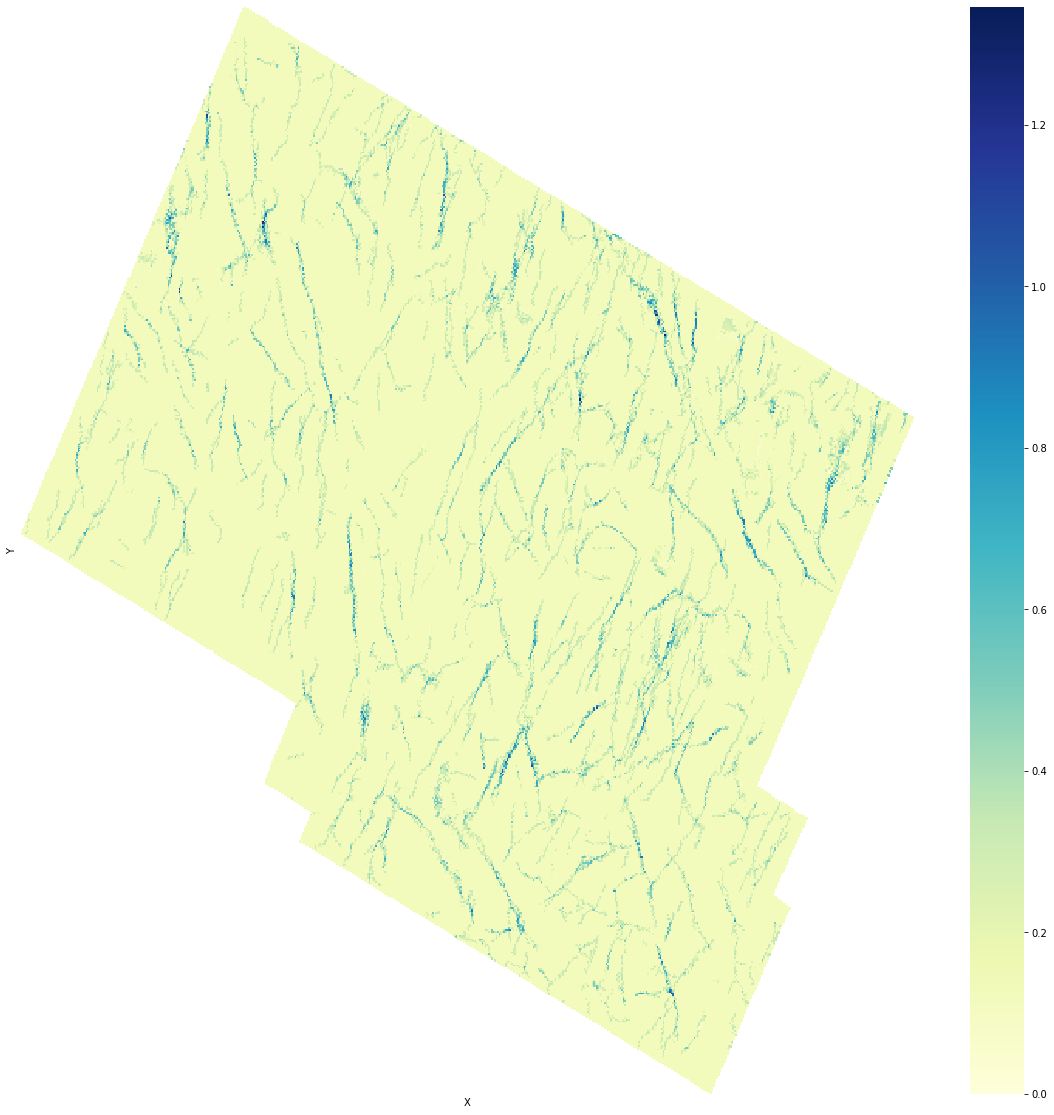

In [4]:
data['value'] = data.value - min(data.value) # сместим систему координат отсчета значений к 0
data = data.round({'value':3})
data['Y'] = data.Y * -1
atr = data.pivot_table( index='Y', 
                        columns='X', 
                        values='value', 
                        aggfunc=sum )

plt.figure(figsize=(20,20))
sns.heatmap(atr, cmap="YlGnBu", xticklabels=False, yticklabels=False)

In [ ]:
df = lin_clf(data, 0.2)
df = calс_fd(df, 1000000)
df.to_csv('C://Users/SMA_9/Desktop/Seismic/data_new.csv')

<a list of 45 text.Text objects>

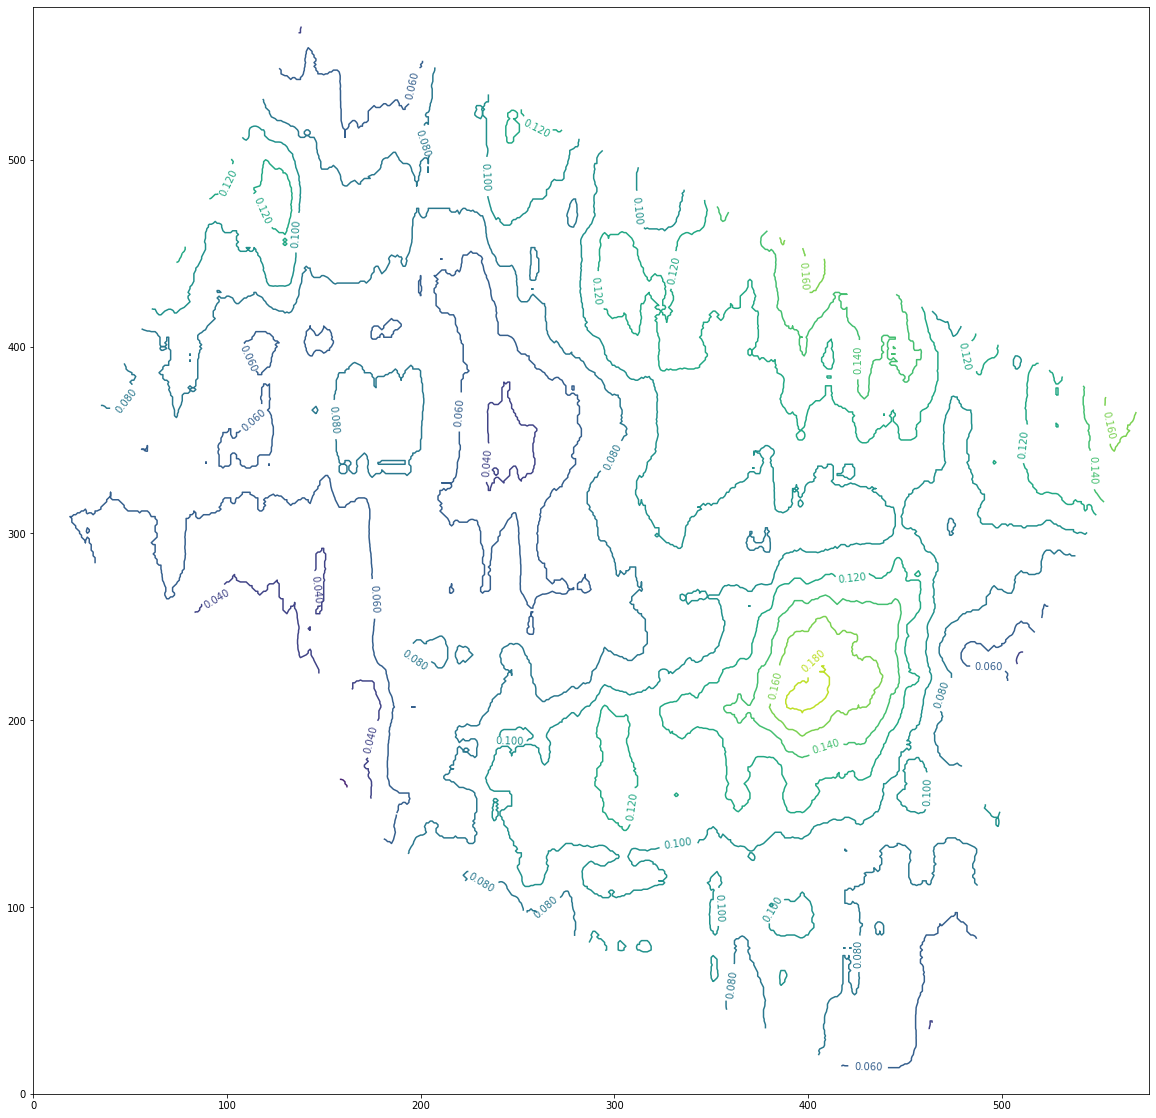

In [5]:
df = pd.read_csv('C://Users/SMA_9/Desktop/Seismic/data_new.csv')
df = df.round({'fd':3})
df['Y'] = df.Y * -1
atr = df.pivot_table( index='Y', 
                      columns='X', 
                      values='fd')

plt.figure(figsize=(20,20))
ax = plt.contour(atr,levels = 8)
plt.clabel(ax)

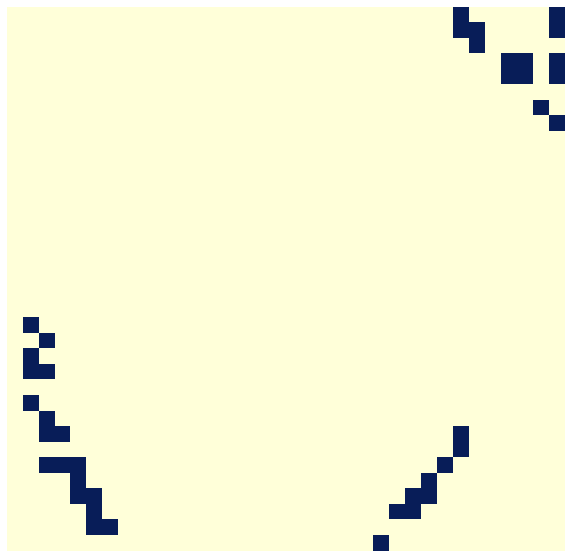

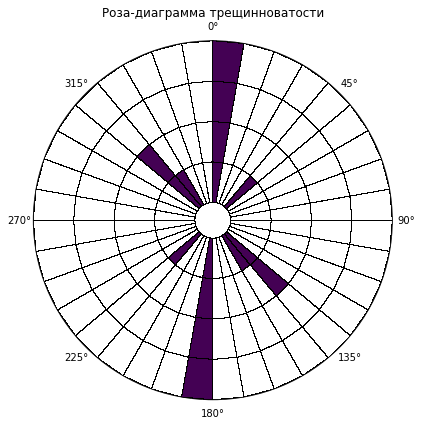

In [17]:
get_sq(df, 358838, 335281, 200000)
build_rose(get_angles(build_plot=False))